# Regression and Other Stories: Coop

Coop - Example of hypothesis testing. See Chapter 4 in Regression and Other Stories.

---

### Load packages

In [1]:
using CSV, HTTP, DataFrames
using StatsPlots, Statistics

### Load data

In [2]:
f_name = "https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Coop/data/Riverbay.csv"
data  = CSV.File(HTTP.get(f_name).body, delim=",", missingstring="NA", header=false) |> DataFrame
votes = data[!, 2:7]
candidate_totals = votes[!,6]
time_totals = sum.(eachcol(votes))
voters = [600,1200,2444,3444,4444,5553]
extras = copy(votes)
extras_voters = copy(voters)
for j in 2:6
    extras[!,j] = votes[!,j] - votes[!,j-1]
    extras_voters[j] = voters[j] - voters[j-1]
end
extras_totals = sum.(eachcol(extras))
names_old = data[!,1]
names = data[!,8]
winners = reverse(sortperm(candidate_totals))
n_candidates = length(winners)
actual = fill(NaN, n_candidates)
expected = fill(NaN, n_candidates);

### Plot

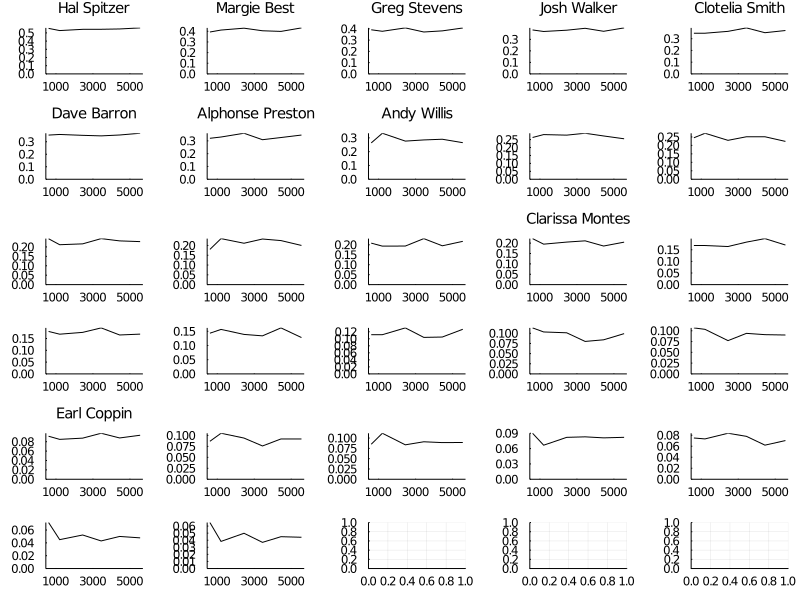

In [3]:
p =  plot( layout=(6,5))
for (plt, i) in enumerate(winners)
    y = Array(extras[i,:]) ./ extras_voters
    plot!(
        p[plt],
        voters, 
        y,
        grid=false,
        xticks=[1000,3000,5000],
        color=:black,
        legend=false,
        ylim=(0,maximum(y)),
        title=replace(names, missing=>"")[i],
        titlefontsize=10,
    )

    p_hat = candidate_totals[i] ./ 5553
    actual[i] = std(y)
    expected[i] = sqrt(mean(p_hat.*(1-p_hat)./extras_voters))
end
plot!(size=(800,600))
display(p)

### Plot

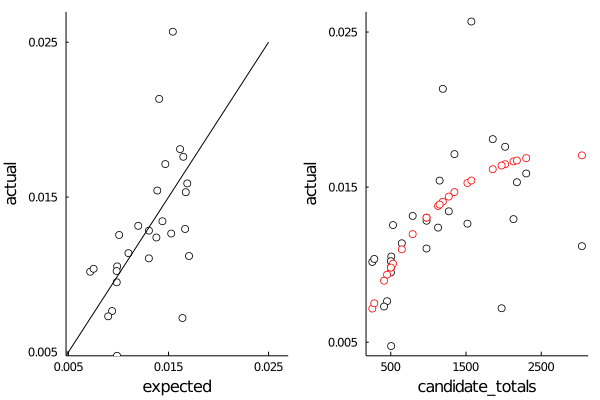

In [4]:
min = minimum(vcat(expected,actual))
max = maximum(vcat(expected,actual))
p1 = scatter(
    expected,
    actual,
    xlim=(min,max*1.05),
    ylim=(min,max*1.05),
    grid=false,
    color=:white,
    ylabel="actual",
    xlabel="expected",
    legend=false,
    xticks=[0.005,0.015,0.025], 
    yticks=[0.005,0.015,0.025] 
)
plot!(
    0.000:0.001:max,
    0.000:0.001:max,
    color=:black,
    kind=:line,
)

p2 = scatter(
    candidate_totals,
    actual,
    grid=false,
    color=:white,
    ylabel="actual",
    xlabel="candidate_totals",
    legend=false,
    xticks=[500,1500,2500],
    yticks=[0.005,0.015,0.025] 
)
scatter!(
    candidate_totals,
    expected,
    color=:white,
    markerstrokecolor=:red,
)

plot(p1,p2, layout=(1,2))

### Plot

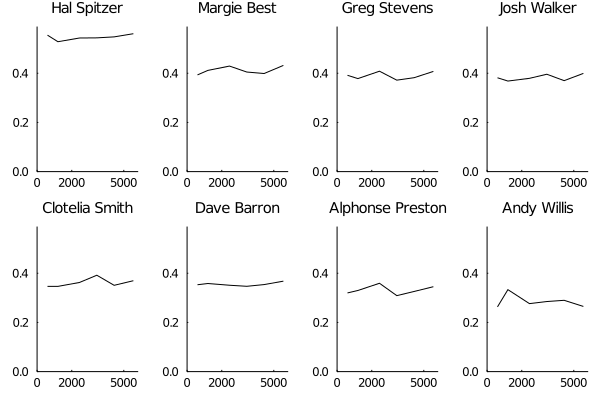

In [5]:
p =  plot( layout=(2,4))
for (plt,i) in enumerate(winners[1:8])
    y = Array(extras[i,:]) ./ extras_voters
    plot!(
        p[plt],
        voters, 
        y,
        grid=false,
        xticks=[0,2000,5000],
        yticks=[0.0, 0.2, 0.4],
        color=:black,
        legend=false,
        ylim=(0,0.59),
        xlim=(0,maximum(voters)*1.05),
        title=replace(names, missing=>"")[i],
        titlefontsize=10,
    )
end
display(p)

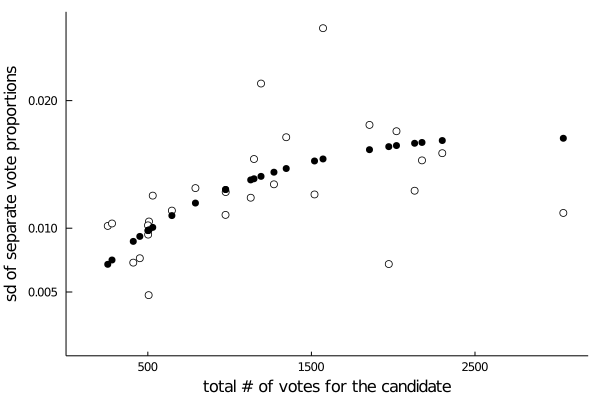

In [6]:
scatter(
    candidate_totals,
    actual,
    xlim=(0,maximum(candidate_totals)*1.05),
    ylim=(0,maximum(actual)*1.05),
    grid=false,
    color=:white,
    legend=false,
    xticks=[500,1500,2500],
    yticks=[0.005,0.010,0.020],
    xlabel="total # of votes for the candidate",
    ylabel="sd of separate vote proportions",
)
scatter!(
    candidate_totals,
    expected,
    color=:black,
)


### chi^2 tests

In [7]:
chisq = fill(NaN, nrow(extras))
for i in 1:nrow(extras)
    observed = vcat(
        Array(extras[i,:]), 
        extras_voters.-Array(extras[i,:])
        )
    expected = vcat(
        extras_voters*sum(extras[i,:])/sum(extras_voters),
        extras_voters*(1-sum(extras[i,:])/sum(extras_voters))
        )
    chisq[i] = sum((observed.-expected).^2 ./ expected)
end

chisq_total = sum(chisq)
df_total = 5 * nrow(extras)
expected_extras = (sum.(eachrow(extras)) * sum.(eachcol(extras))') / sum(Array(extras))
chisq_extras = sum((Matrix(extras) .- expected_extras).^2 ./ expected_extras)
df_extras = (27-1)*(6-1);